## Imports

In [1]:
#essential imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#nlp
import spacy

## Functions

In [2]:
#given the book, converts to one large string
def read_book(book):
    
    #read the text
    with open(book,'r') as file:###
        lines = file.read().splitlines()

    #combine the lines into single string
    text = ' '.join(lines)
    text = text.lower()
    
    return text

#processes the string into tokens
def preprocess(text, nlp, language, lemmatize = True):
    
    #case folding
    #unnecessary since lemmas are lower cased
    #and while names aren't, they don't need to be
    #text = text.lower()
    
    #tokenize and process the text 
    tokens = nlp(text)
    
    #get rid of punctuation
    tokens = [token for token in tokens if (not token.is_punct)]
    
    #get rid of proper nouns (names and places)
    tokens = [token for token in tokens if (not token.tag_ == 'PROPN')]
    
    #get rid of numbers
    tokens = [token for token in tokens if (not token.like_num)]
    
    #only include lemmas
    if lemmatize:
        
        tokens = [token.lemma_ for token in tokens]
        
    else:
        #since otherwise the lemmas are already lowercased
        #(i think...)
        tokens = [token.text.lower() for token in tokens]
        
    #add a functionality that verifies whether each
    #word occurs in a dictionary
    
    return tokens

#counts the occurences of unique lexemes
#and also computes corresponding log-values
def count(tokens, N):
    
    #each unique lemma in the tokens
    unique_tokens = list(set(tokens))

    #counts the number of unique lemmas processed
    #while reading the book to measure vocab growth
    unique_token_counts = [[] for i in range(len(N))]

    #pandas series to track how many times
    #each unique lemma occurs
    freq_tokens = pd.Series(dtype='int64')

    #assign unique lemmas as keys and
    #initialize counts to 0
    for token in unique_tokens:
    
        freq_tokens[token] = 0
        
        
    ###########
        
    most_recent_unique_lemma = ""
    most_recent_unique_lemmas = []
    #iterate through the lemmas
    for index in range(len(tokens)):

        #add occurence of lemma
        freq_tokens[tokens[index]] += 1
        
        #if we just saw a new unique lemma for the first time
        if freq_tokens[tokens[index]] == 1:
            
            most_recent_unique_lemma = tokens[index]
            
        most_recent_unique_lemmas.append(most_recent_unique_lemma)

        #counts the number of unique lemmas that have occured more
        #than n times for each n-value listed in N
        for i in range(len(N)):
            
            n = N[i]
            
            unique_token_counts[i].append(  (freq_tokens >= n).sum()  )
            
    #store results in a dataframe
    token_counts_df = pd.DataFrame(unique_token_counts)
    token_counts_df = token_counts_df.T
    
    #change column names: column for number of lexemes read
    token_counts_df.columns = ['unique_lexemes_read']
    
    #column for number of lexemes read
    token_counts_df['lexemes_read'] = token_counts_df.index + 1
    
    #change column order
    token_counts_df = token_counts_df[['lexemes_read', 'unique_lexemes_read']]
    
    token_counts_df['most_recent_unique_lexeme'] = most_recent_unique_lemmas
    
    #calculate the logarithms of the first two columns for the log-log plot
    token_counts_df['log_lexemes_read'] = np.log(token_counts_df['lexemes_read'])
    token_counts_df['log_unique_lexemes_read'] = np.log(token_counts_df['unique_lexemes_read'])
    
    return token_counts_df

#plots the Heaps' Law vocab growth curve
#as well as it's log-log plot
def plot(token_counts_df, language):
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    #create x-axis for the plot    
    #x_axis = list(token_counts.index)
    
    fig.set_figheight(10)
    fig.set_figwidth(20)
    
    for n in token_counts_df.columns:
        
        ax1.plot(token_counts_df['lexemes_read'], token_counts_df['unique_lexemes_read'])
        
        ax2.plot(token_counts_df['log_lexemes_read'], token_counts_df['log_unique_lexemes_read'])
        
    fig.suptitle(language, fontsize=35)

# Analyze the Texts

In [3]:
languages = ['English', 'French', 'Greek']

books = {'English':'English/Pride and Prejudice.txt', 'French':'French/Madame Bovary.txt',
         'Greek':'Greek/The Illiad (Ιλιάδα).txt'}

nlps = {'English':spacy.load("en_core_web_sm"), 'French':spacy.load("fr_core_news_sm"), 
        'Greek':spacy.load("el_core_news_sm")}

#will store all the df's for the
#different languages
token_counts_dfs = {}
for language in languages:
    
    book = books[language]
    nlp = nlps[language]
    
    book_text = read_book(book)
    
    tokens_lemmas = preprocess(book_text, nlp, language)
    
    #have a token limit since some books here are
    #longer than the others
    #tokens_lemmas = tokens_lemmas[:110000]
    
    token_counts_df = count(tokens_lemmas, [1])
    
    token_counts_dfs[language] = token_counts_df
    
    #save the data to a data frame
    token_counts_df.to_csv(language + '/' + language.lower() + '_token_counts.csv', index = False)

# Plot the results

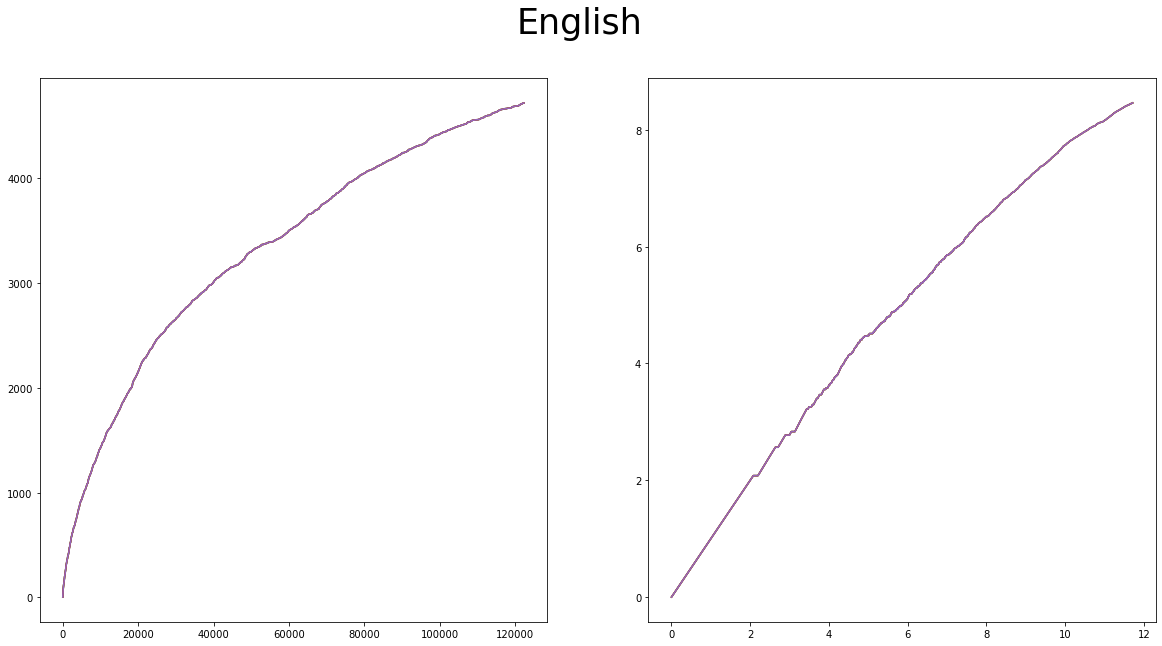

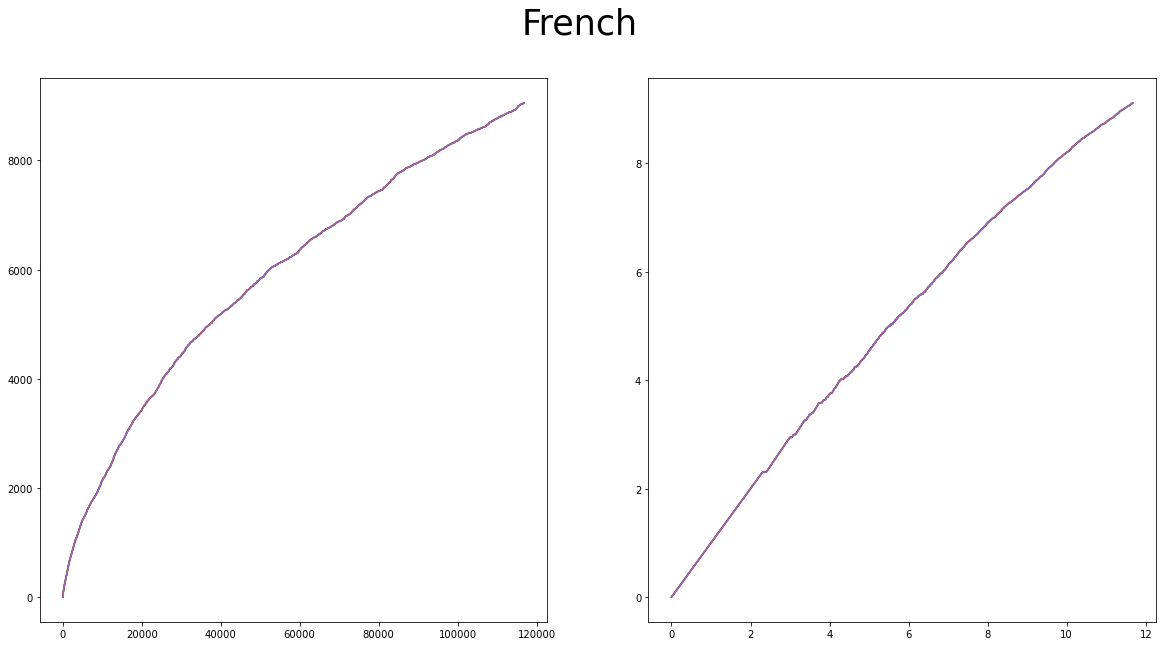

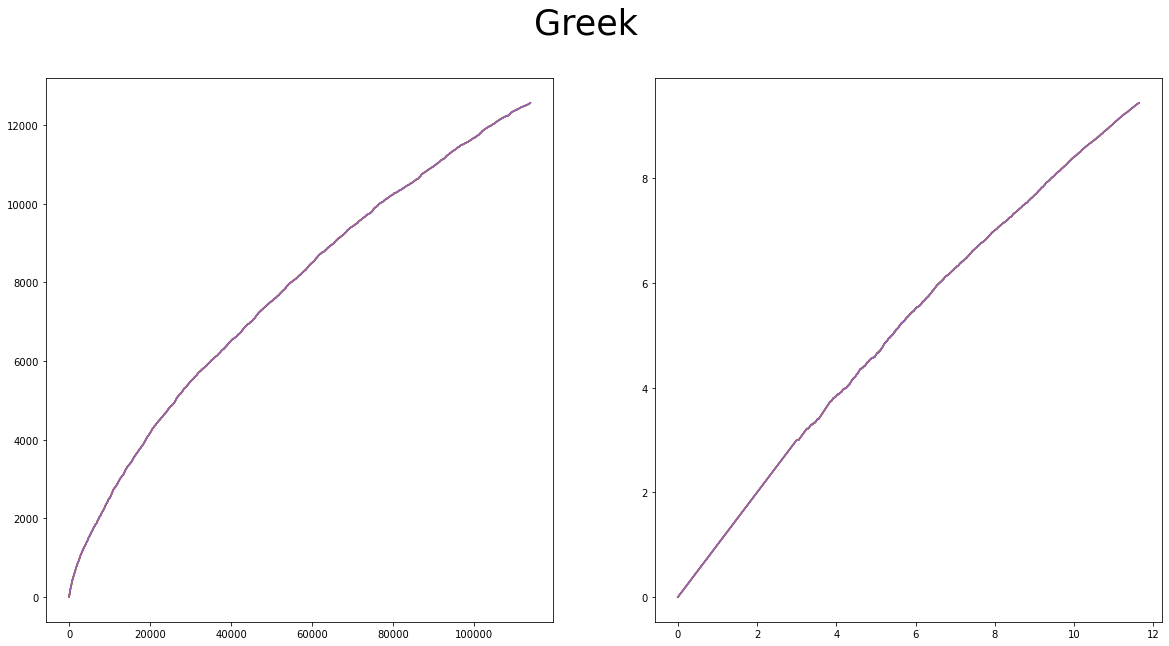

In [4]:
for language in languages:
    
    plot(token_counts_dfs[language], language)